In [1]:
# lets do simulations / images with a crowded field, on the optimised pupil
# probably just calculate fisher info of everything
# / cramer rao bounds as a multiple of airy disk cramer raos

# Core jax
import jax
# from jax.config import config
jax.config.update("jax_enable_x64", True)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT

# Plotting/visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from dLuxToliman import ApplyBasisCLIMB, TolimanOpticalSystem

# gonna have to define my own log likelihoods which are analytic contiuations???

from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'magma'

from pathlib import Path

In [185]:
# jax random key
# key = jr.PRNGKey(588)

wf_npix = 256 
diameter = 1 # 1 meter diameter

wavelength = 1e-6 # 1 micron wavelength

# This is to what degree we undersample Nyquist
nyquist_factor = 1
psf_npix = 64 / nyquist_factor
psf_pixel_scale = nyquist_factor * dlu.rad2arcsec(wavelength/(2*diameter))
oversample = nyquist_factor * 4 # sample at 4x nyquist originally

flux = 1e8
source = dl.PointSource(np.array([wavelength]), np.array([0,0]), flux=flux)

# import the particular pupil
pupil = np.load("../xk10/goodergrating.npy")

#aperture_layer = dlT.TolimanApertureLayer(wf_npix)

wf_oversample = 5

# Generate a set of coordinates
coords = dlu.pixel_coords(wf_npix * wf_oversample, diameter)

# Generate outer aperture
primary = dlu.circle(coords, diameter/2) #toliman secondary mirror size

# Generate secondary mirror occultation
m2_diam = 0.256*diameter # 30.5 cm
secondary = dlu.circle(coords, m2_diam/2, invert=True)

# Generate spiders
# martinache spider
spider_width = m2_diam/2 # 38 mm
angles = [90]
spiders = dlu.spider(coords, spider_width, angles)

# Combine and downsample
aperture = dlu.combine([primary, secondary], wf_oversample)
aperture_Martinache = dlu.combine([primary, secondary, spiders], wf_oversample)

# Zernike aberrations
zernike_indices = np.arange(4, 11)
coeffs = np.zeros_like(zernike_indices)
coords_zernike = dlu.pixel_coords(wf_npix, diameter)
basis = dlu.zernike_basis(zernike_indices, coords_zernike, diameter)

aperture_layer = dl.layers.BasisOptic(basis, aperture, coeffs, normalise=True)
aperture_M_layer = dl.layers.BasisOptic(basis, aperture_Martinache, coeffs, normalise=True)

pupil_layer = dl.AberratedLayer(phase = pupil)

layers = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'pupil',
        pupil_layer
    )
]

layers_Martinache = [
    (
        'aperture',
        aperture_M_layer
    )
]

flux_Martinache = np.count_nonzero(optics_Martinache.transmission)/np.count_nonzero(optics.transmission) * flux # to account for lost flux

source_Martinache = dl.PointSource(np.array([wavelength]), np.array([0,0]), flux=flux_Martinache)

optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)
optics_Martinache = dl.AngularOpticalSystem(wf_npix, diameter, layers_Martinache, psf_npix, psf_pixel_scale, oversample)

telescope = dl.Telescope(optics, source)
telescope_Martinache = dl.Telescope(optics_Martinache, source_Martinache)

psf = telescope.model()
psf_Martinache = telescope_Martinache.model()

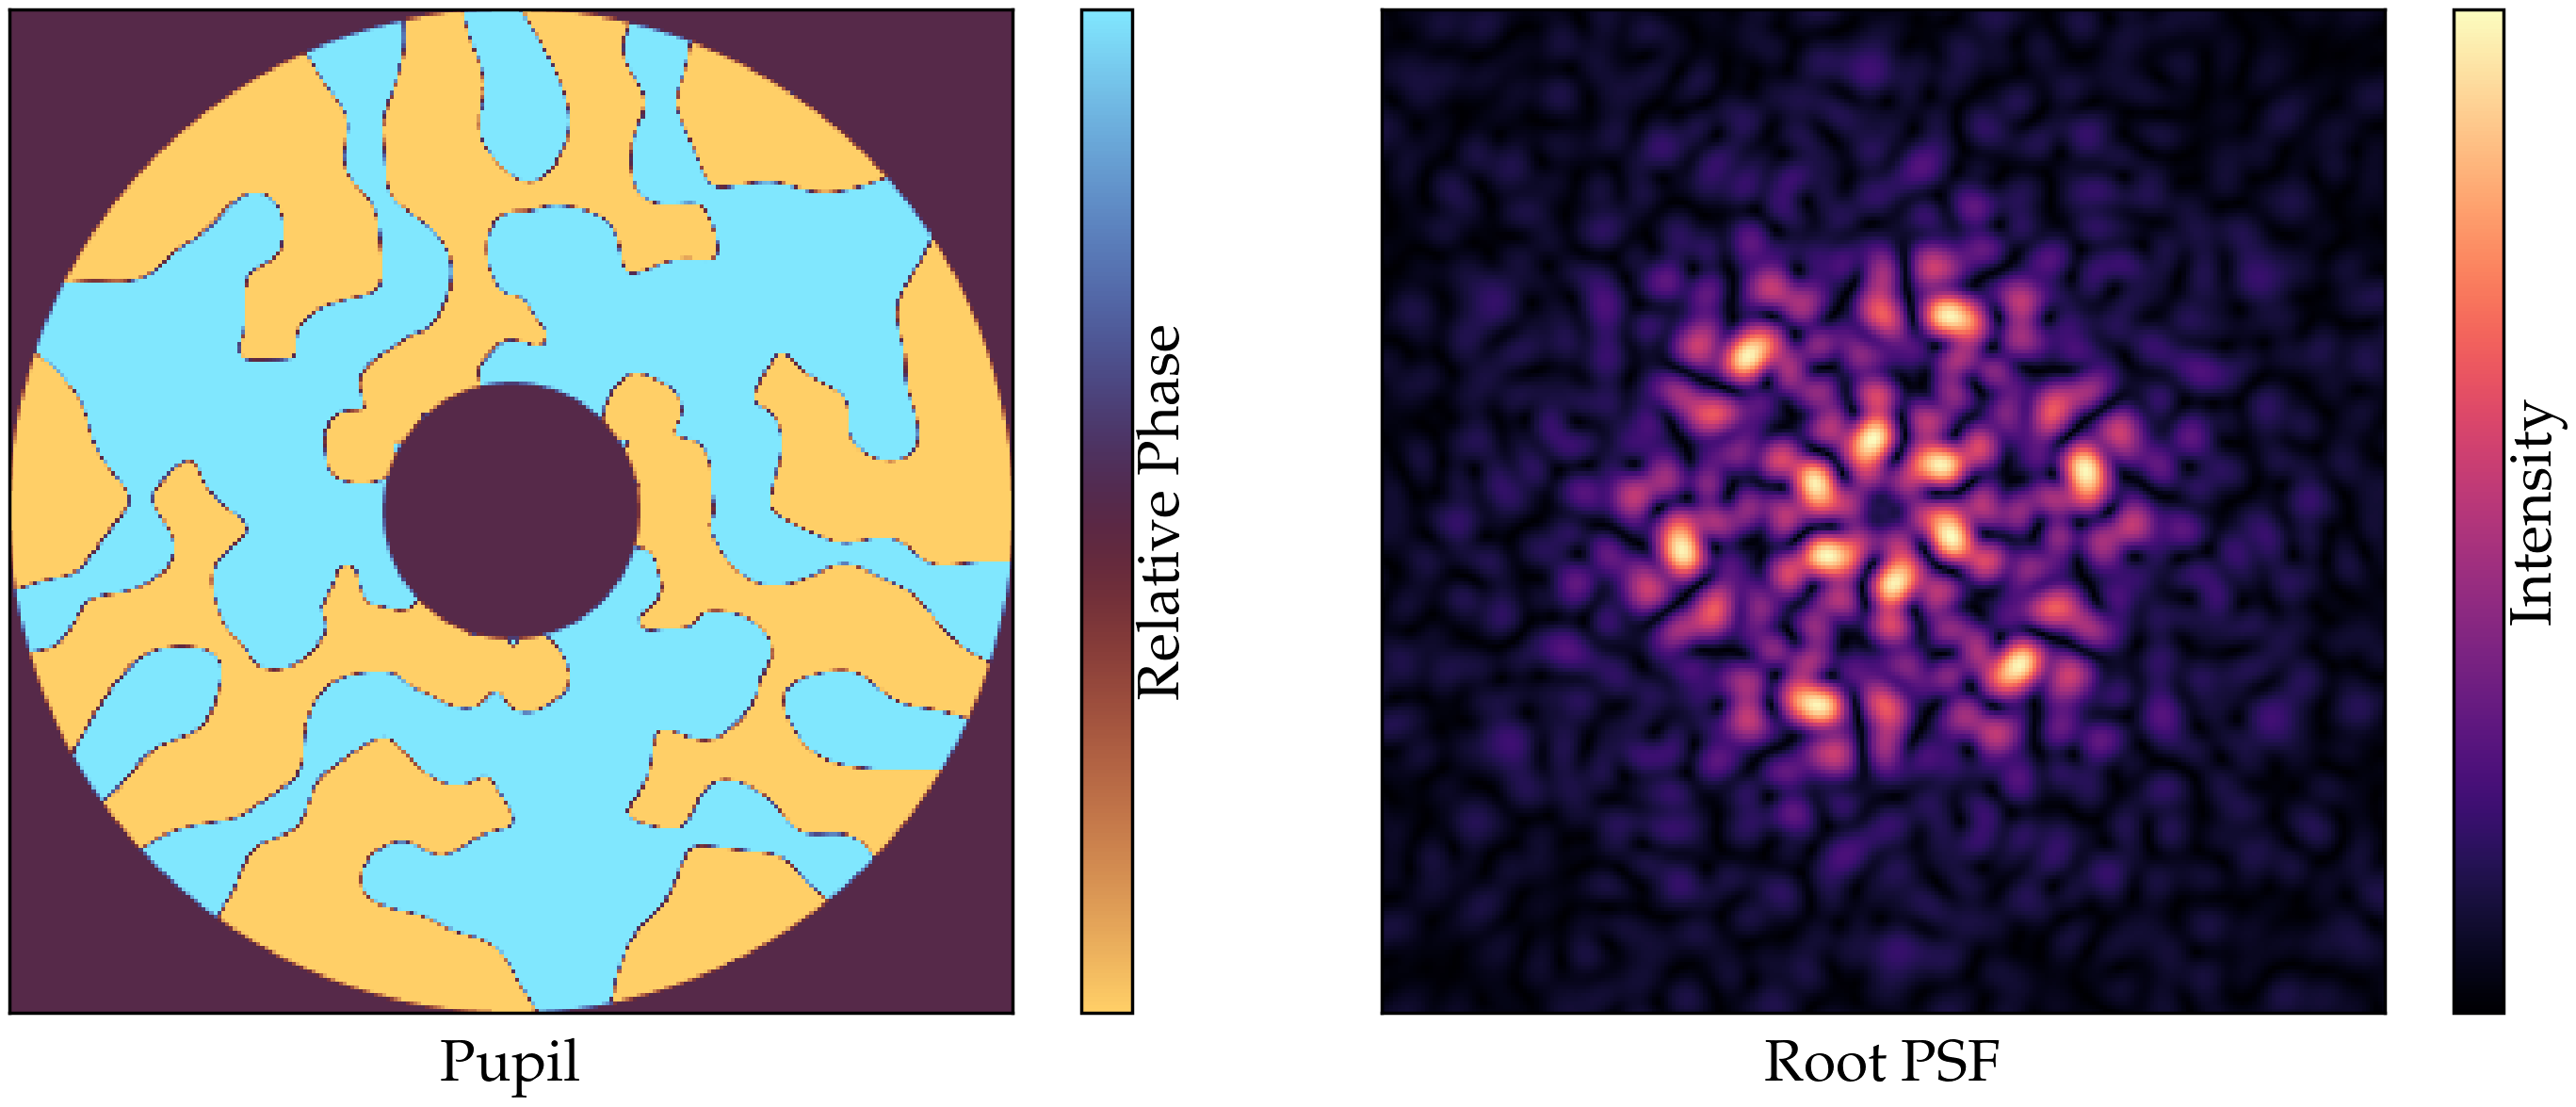

In [186]:
plt.style.use('../wk17/sty.mplstyle')
plt.rcParams["image.cmap"] = 'magma'
plt.rcParams["image.origin"] = 'lower'

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
plt.imshow((pupil/np.max(pupil)*2 - 1)*optics.transmission, cmap='managua')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label('Relative Phase')
plt.xlabel('Pupil', labelpad=20)

plt.subplot(1,2,2)
plt.imshow(psf**0.5)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label('Intensity')
plt.xlabel('Root PSF', labelpad=20)

plt.tight_layout()

#plt.savefig('gratingpupil.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# need to get covariances
marginal_params = 'aperture.coefficients'

fisher_pupil = zdx.fisher_matrix(telescope, marginal_params, poiss_loglike, data=psf)
fisher_Martinache = zdx.fisher_matrix(telescope_Martinache, marginal_params, poiss_loglike, data=psf_Martinache)

cov_pupil = np.linalg.inv(fisher_pupil)
cov_Martinache = np.linalg.inv(fisher_Martinache)

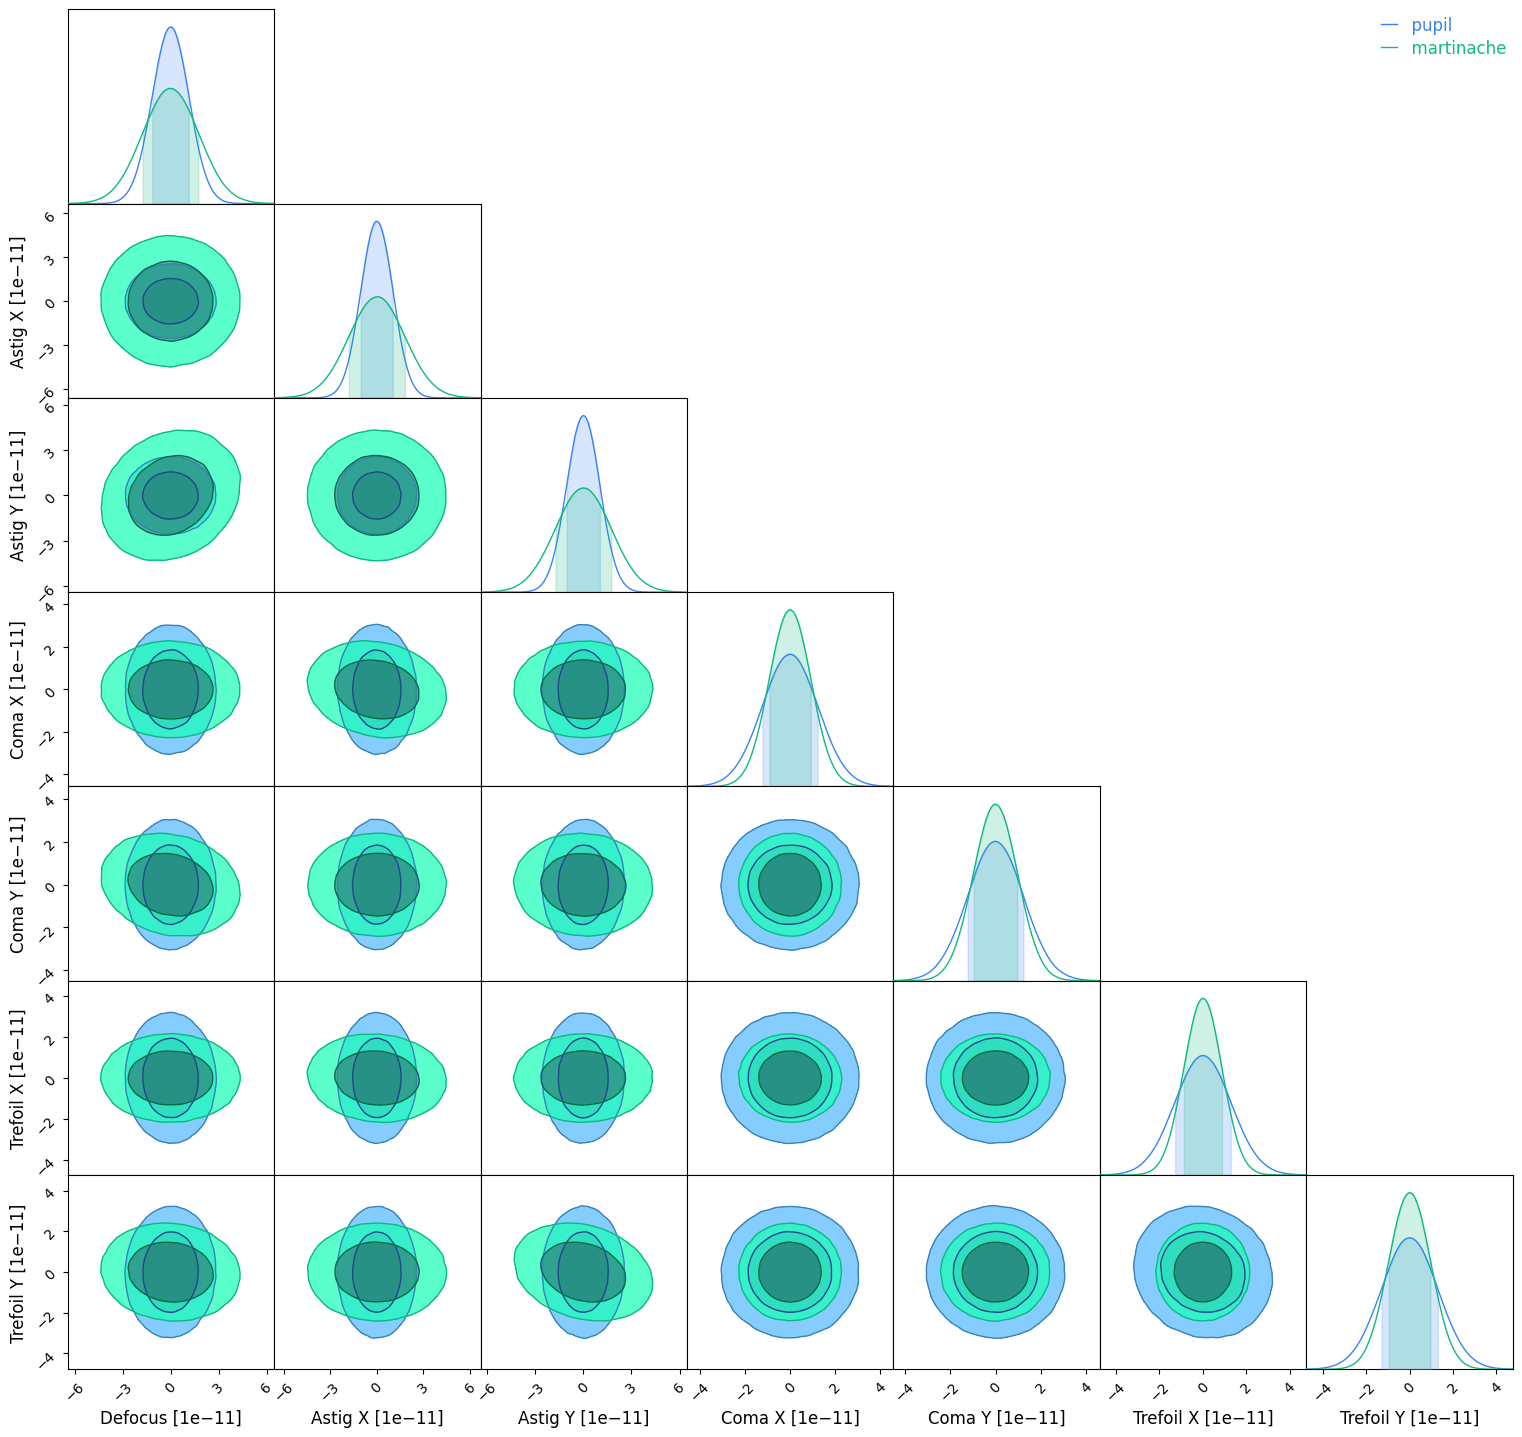

In [55]:
# have to make the last figure; the fisher information at pos1 and pos2
from chainconsumer import ChainConsumer, Chain, Truth
plt.style.use('default')

param_names = [dlu.zernike_name(i) for i in np.arange(4,11)]
X = np.zeros(len(param_names))

# no posangle
# param_names = ['separation', 'mean_flux', 'contrast_ratio','spec_grad', 'pos_x', 'pos_y']
# X = np.array([separation, flux, contrast, spec_grad, 0, 0])

# no flux
# param_names = ['separation','pos_angle', 'contrast_ratio','spec_grad', 'pos_x', 'pos_y']
# X = np.array([1000*dlu.rad2arcsec(separation), 90, contrast, spec_grad, 0, 0])

c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_pupil, columns=param_names, name="pupil")
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_Martinache, columns=param_names, name="martinache")
)

#c.add_truth(Truth(location={param_names[0]: 1000*dlu.rad2arcsec(separation), param_names[1]: 0, param_names[2]: 2.5e8, 
#                            param_names[3]: contrast, param_names[4]: spec_grad, param_names[5]: 0, param_names[6]: 0}))


fig = c.plotter.plot()

In [59]:
relative_sigmas = np.array([np.sqrt(cov_pupil/cov_Martinache)[i,i] for i in np.arange(0,7)])

In [97]:
print(np.min(pupil))

0.0


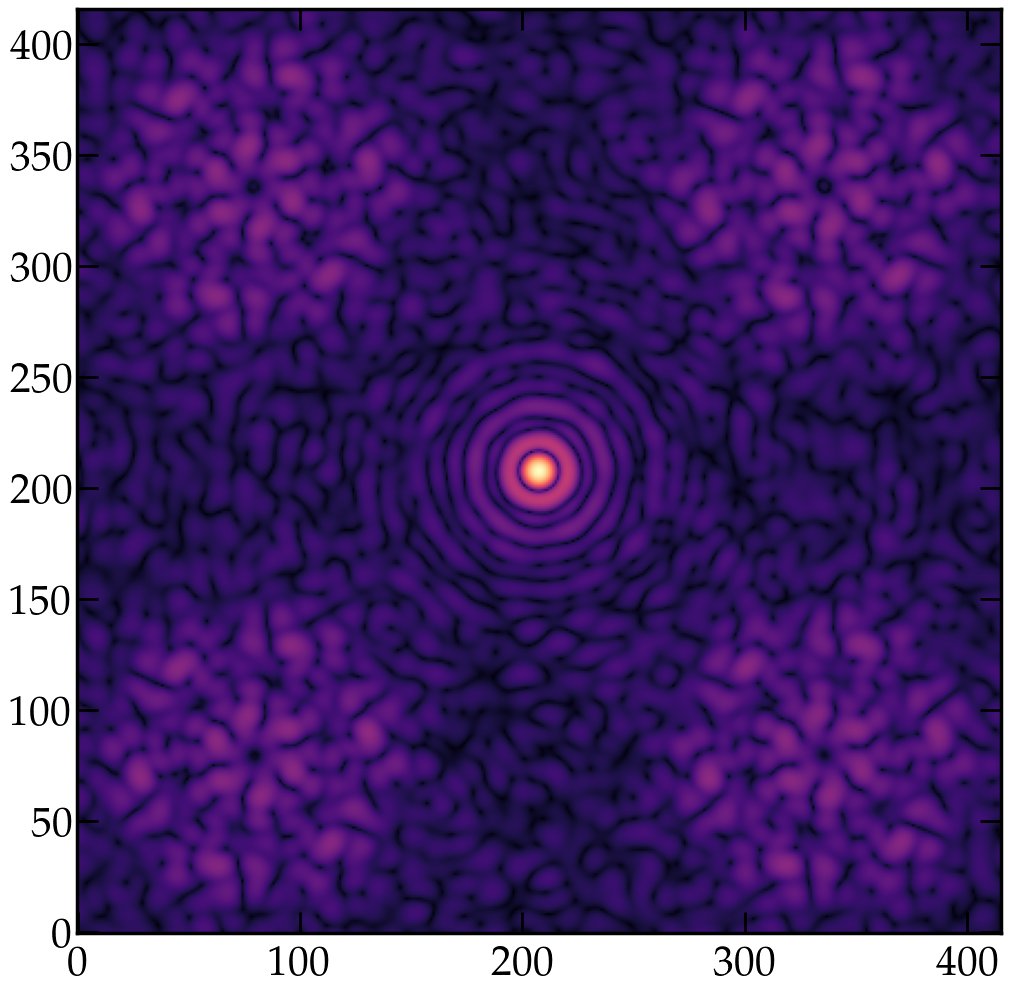

In [111]:
# let us generate the grating image
grating = dlT.PhaseGratingLayer(wf_npix, diameter, diameter/16, 1.35*np.pi).phase

grating *= (pupil/np.max(pupil)*2-1)

grating_layer = dl.layers.AberratedLayer(phase=grating)

layers_grate = [
    (
        'aperture',
        aperture_layer
    ),
    (
        'grating',
        grating_layer
    )
]

optics_grate = dl.AngularOpticalSystem(wf_npix, diameter, layers_grate, 104, psf_pixel_scale, oversample)

telescope_grate = dl.Telescope(optics_grate, source)

psf_grate = telescope_grate.model()

plt.imshow(psf_grate**0.2)

<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:36: SyntaxWarning: invalid escape sequence '\%'
<>:28: SyntaxWarning: invalid escape sequence '\%'
<>:36: SyntaxWarning: invalid escape sequence '\%'
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_38419/3650964922.py:28: SyntaxWarning: invalid escape sequence '\%'
  f'{-(1-val)*100:.0f}\%',                              # label text
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_38419/3650964922.py:36: SyntaxWarning: invalid escape sequence '\%'
  f'+{(val-1)*100:.0f}\%',                              # label text


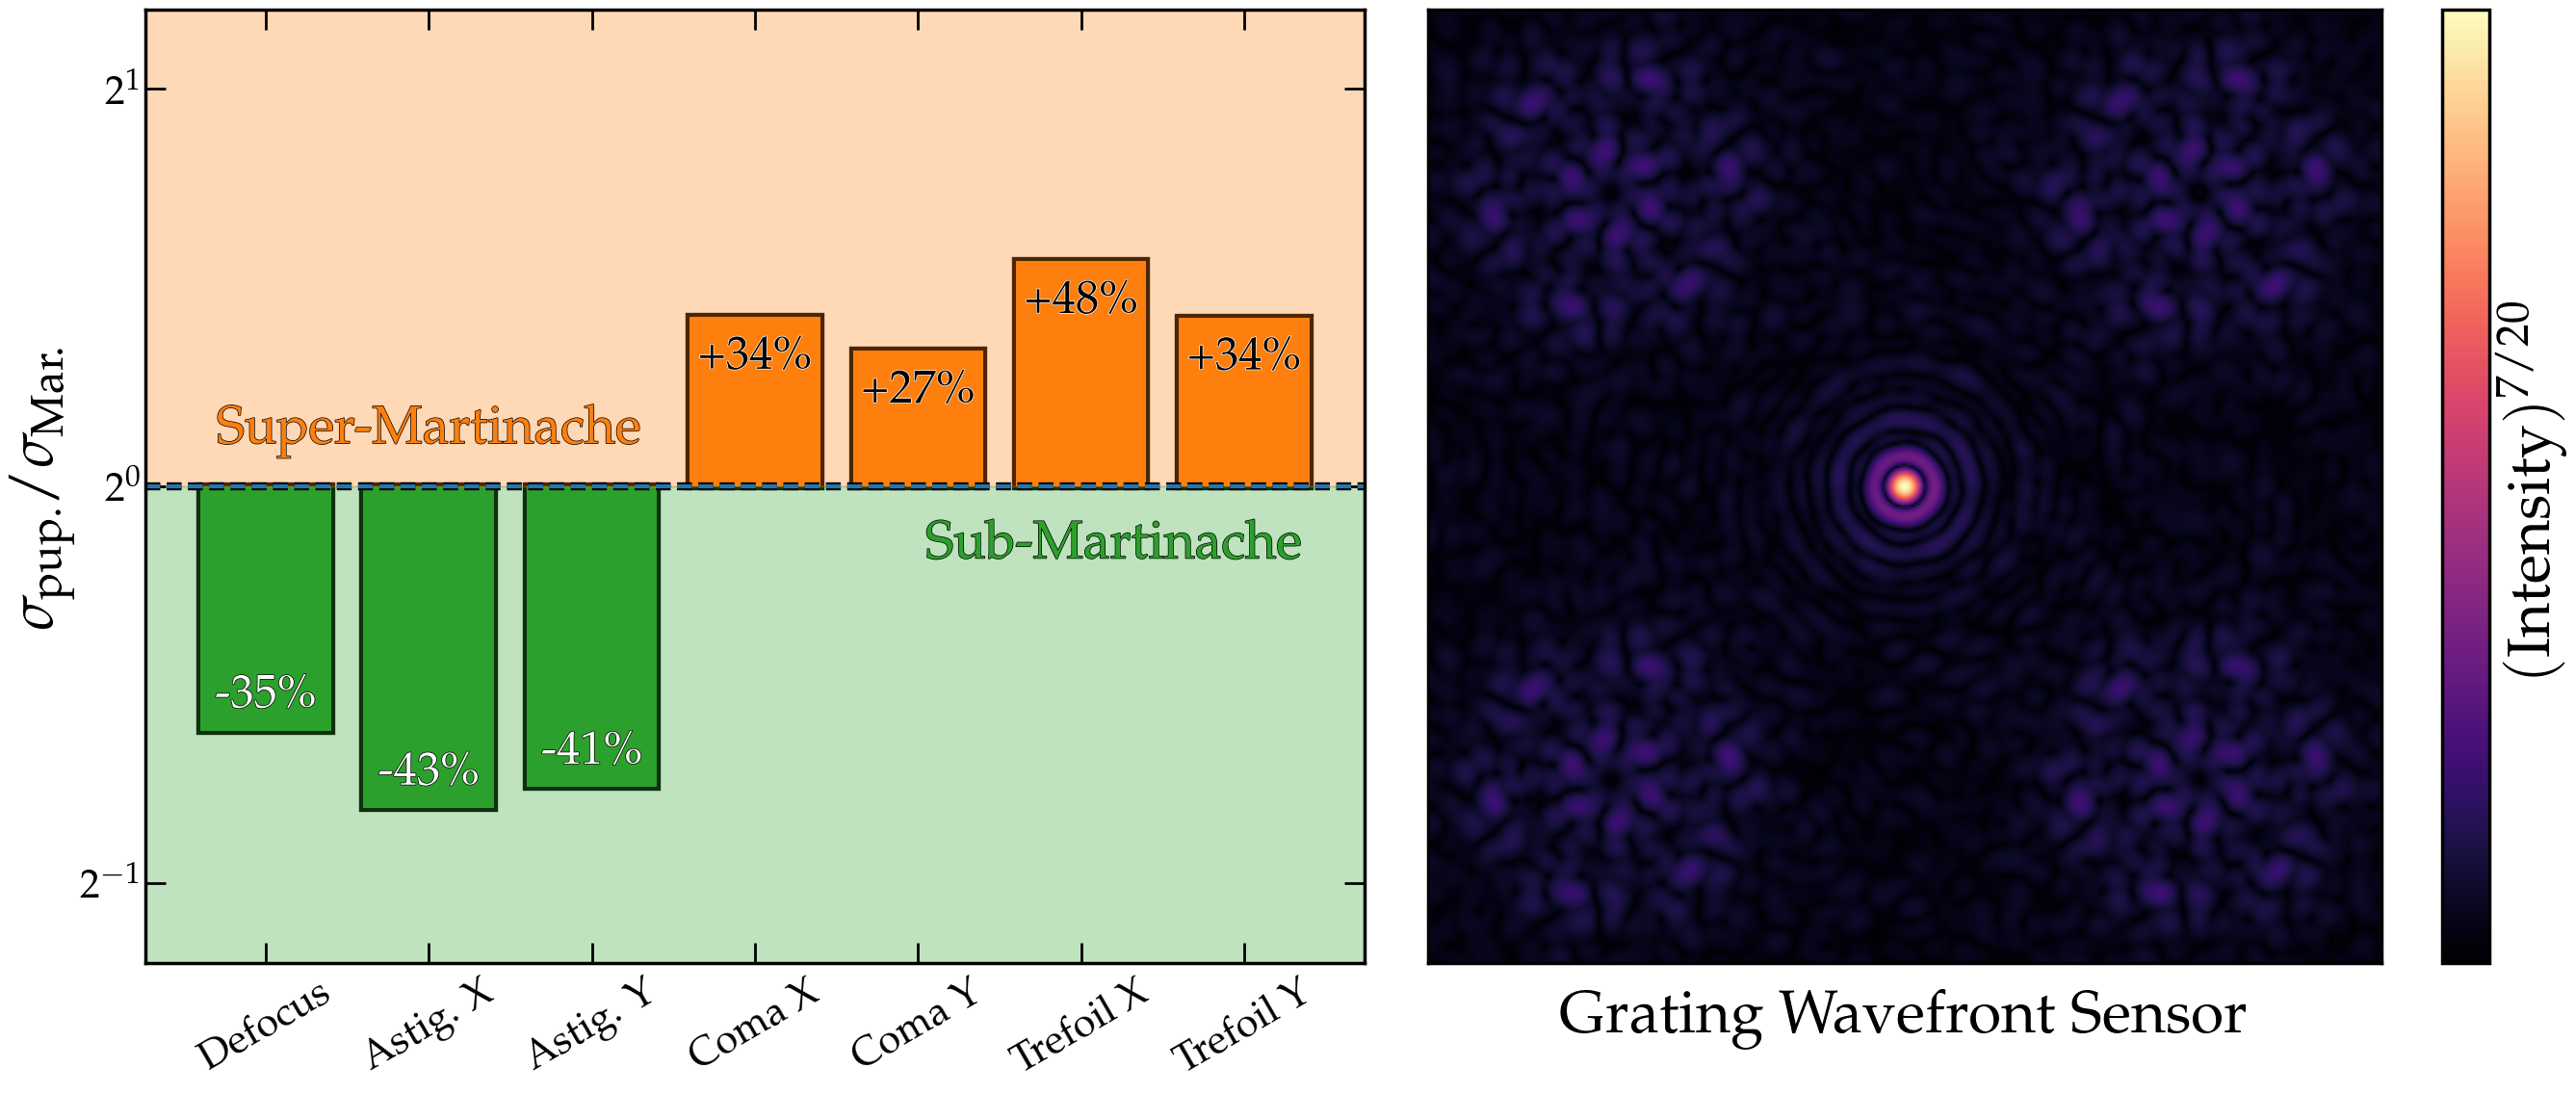

In [ ]:
param_names_2 = ['Defocus', 'Astig. X', 'Astig. Y', 'Coma X', 'Coma Y', 'Trefoil X', 'Trefoil Y']
plt.style.use('../wk17/sty.mplstyle')
plt.rcParams["image.cmap"] = 'magma'
plt.rcParams["image.origin"] = 'lower'

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
w_text_path_effects=[pe.Stroke(linewidth=1, foreground='white'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

heights = relative_sigmas - 1
y_bottoms = np.minimum(relative_sigmas, 1)

plt.figure(figsize=(28,12))
plt.subplot(1,2,1)
bars1 = plt.bar(param_names_2[:3], np.abs(heights[:3]), bottom=y_bottoms[:3], path_effects=path_effects, color='tab:green')
bars2 = plt.bar(param_names_2[3:], np.abs(heights[3:]), bottom=y_bottoms[3:], path_effects=path_effects, color='tab:orange')
plt.axhline(1, color='tab:blue', ls='--', path_effects=path_effects)
plt.ylim(2**(-1.2),2**(1.2))
plt.yscale('log', base=2)
plt.xticks(rotation=30)
plt.ylabel(r'$\sigma_{\mathrm{pup.}}/\sigma_{\mathrm{Mar.}}$')

for bar, val in zip(bars1, relative_sigmas[:3]):
    plt.text(
        bar.get_x() + bar.get_width()/2,           # x-center
        (bar.get_y())*1.06,          # y-center
        f'{-(1-val)*100:.0f}\%',                              # label text
        ha='center', va='center', color='white', fontsize=35, path_effects=text_path_effects
    )

for bar, val in zip(bars2, relative_sigmas[3:]):
    plt.text(
        bar.get_x() + bar.get_width()/2,           # x-center
        (bar.get_y() + bar.get_height())*0.93,          # y-center
        f'+{(val-1)*100:.0f}\%',                              # label text
        ha='center', va='center', color='black', fontsize=35, path_effects=w_text_path_effects
    )
# now let us colour the regions
plt.axhspan(0, 1, color='tab:green', alpha=0.3)   
plt.axhspan(1, 4, color='tab:orange', alpha=0.3) 

plt.text(
    1,
    1.1,
    'Super-Martinache',
    ha='center', va='center', color='tab:orange', fontsize=40, path_effects=text_path_effects
)

plt.text(
    5.2,
    0.9,
    'Sub-Martinache',
    ha='center', va='center', color='tab:green', fontsize=40, path_effects=text_path_effects
)

plt.subplot(1,2,2)
plt.imshow(psf_grate**0.35, origin='lower', cmap='magma')
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_label(r'$(\mathrm{Intensity})^{7/20}$')
plt.xticks([])
plt.yticks([])
plt.xlabel('Grating Wavefront Sensor', labelpad=20)

plt.tight_layout()
#plt.savefig('martinache_grating.pdf',dpi=300,bbox_inches='tight')
plt.show()